# KSD Bandwidth sweep

In [1]:
import sys
import os
sys.path.append("/home/lauro/code/msc-thesis/svgd/kernel_learning")
import json_tricks as json
import copy

from tqdm import tqdm
import jax.numpy as np
from jax import grad, jit, vmap, random, lax, jacfwd, value_and_grad
from jax import lax
from jax.ops import index_update, index
import matplotlib.pyplot as plt
import numpy as onp
import jax
import pandas as pd
import haiku as hk
from jax.experimental import optimizers

import config

import utils
import metrics
import time
import plot
import stein
import kernels
import svgd
import distributions
import nets

from jax.experimental import optimizers

key = random.PRNGKey(0)

/home/lauro/.virtualenvs/msc-thesis/lib/python3.8/site-packages/jax/lib/xla_bridge.py:125: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


# Summary
Assume proposal $\mathcal N(0,1)$ and target $\mathcal N(1,1)$. Sample 400 particles from proposal.
Then KSD U-estimator has following bandwidth dependent dynamics:
* bandwidth $h<10^{-2}$: high variance, estimates from ~ -100 to 100. The true KSD is probably close to zero.
* bandwidth $10^{-2} < h < 10$: KSD grows from <0.1 to ca. 0.9. Variance still decently large.
* bandwidth $h>10$: KSD stays constant (kernel is essentially equal to $1$ everywhere)

## The weirdest part
KSD is *greatest* in the latter regime, where the bandwidth is totally indiscriminate. This is contrary to intuition---large KSD should mean a bandwidth that discriminates well.

In [2]:
# initialize kernel, proposal dist, and target dist
def get_rbf_fn(bandwidth):
    logh = np.asarray(bandwidth)
    logh = np.squeeze(bandwidth)
    def rbf(x, y): return np.exp(- np.sum((x - y)**2 / bandwidth**2) / 2)
    return rbf
scale=5
# mean = scale*1
# stddev = scale*1
proposal = distributions.Gaussian(0, 1)
target   = distributions.Gaussian(0, 25)

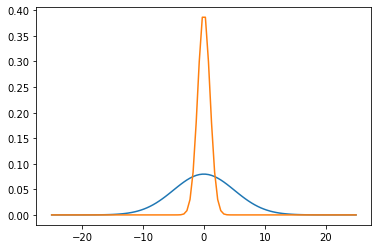

In [3]:
lgrid = np.linspace(-5*scale, 5*scale, 100)
plt.plot(lgrid, vmap(target.pdf)(lgrid))
plt.plot(lgrid, vmap(proposal.pdf)(lgrid))

In [4]:
# comparison kernels
def constant(x, y): return np.array(1.)
def null(x, y): return np.array(0.)
def get_tophat_fn(bandwidth):
    def tophat(x, y): return np.squeeze(np.where(np.abs(x-y)<bandwidth, 1., 0.))
    return tophat

## sweep

In [5]:
@jit
def compute_ksds(p):
    rbf = get_rbf_fn(p)
    tophat = get_tophat_fn(p)
    ksd_rbf = stein.ksd_squared_u(samples, target.logpdf, rbf,    False)
    ksd_top = stein.ksd_squared_u(samples, target.logpdf, tophat, False)
    return ksd_rbf, ksd_top

In [6]:
n = 200
grid = 2**np.linspace(-4, 5, 25)
m=10
ksds_rbf = []
ksds_top = []
for _ in tqdm(range(m)):
    grid_ksds_rbf = []
    grid_ksds_top = []
    samples = proposal.sample(n)
    for p in grid:
        ksd_rbf, ksd_top = compute_ksds(p)
        grid_ksds_rbf.append(ksd_rbf)
        grid_ksds_top.append(ksd_top)
    ksds_rbf.append(grid_ksds_rbf)
    ksds_top.append(grid_ksds_top)

100%|██████████| 10/10 [00:01<00:00,  6.19it/s]


In [7]:
ksds_rbf = np.array(ksds_rbf)
ksds_top = np.array(ksds_top)

grid_means_rbf = np.mean(ksds_rbf, axis=0)
grid_means_top = np.mean(ksds_top, axis=0)

grid_var_rbf = np.std(ksds_rbf, axis=0)
grid_var_top = np.std(ksds_top, axis=0)

In [8]:
temp=[]
for _ in range(20):
    samples = proposal.sample(n)
    ksd_c = stein.ksd_squared_u(samples, target.logpdf, constant, False)
    temp.append(ksd_c)
ksd_c = onp.mean(ksd_c)

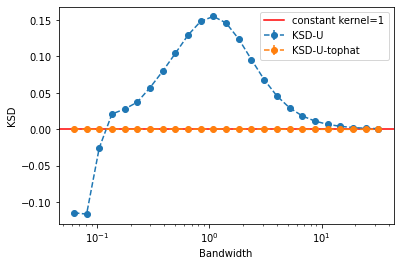

In [13]:
plt.errorbar(grid, grid_means_rbf, yerr=grid_var_rbf, fmt="--o", label="KSD-U")
plt.errorbar(grid, grid_means_top, yerr=grid_var_top, fmt="--o", label="KSD-U-tophat")
plt.axhline(y=ksd_c, label="constant kernel=1", color="r")
plt.xscale("log")
plt.ylabel("KSD")
plt.xlabel("Bandwidth")
plt.legend()

## asymptote at $k(x, y) = 1$ is not scale-invariant

In [10]:
scales = np.linspace(1, 100, 100)
n = 400
ksds=[]
for scale in tqdm(scales):
    mean = scale*1
    stddev = scale*1
    proposal = distributions.Gaussian(0,stddev**2)
    target = distributions.Gaussian(mean, stddev**2)
    samples = proposal.sample(n)
    
    ksds.append(stein.ksd_squared_u(samples, target.logpdf, constant, False))

100%|██████████| 100/100 [00:20<00:00,  4.87it/s]


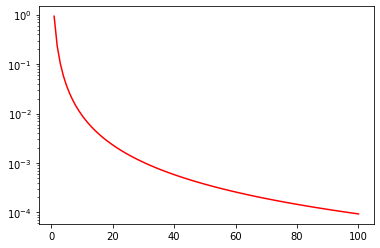

In [11]:
plt.plot(scales, ksds, "r")
plt.yscale("log")